# DOPP 2019W Exercise 2

### Before you get started, please read the instructions in this notebook carefully.

## Preliminaries

- Please use only Python **version 3** (3.6+ recommended). It is recommended to install Anaconda or Miniconda. 

- This notebook will be scored using [nbgrader][https://nbgrader.readthedocs.io/en/stable/user_guide/highlights.html]. 
- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers. 
- Check and make sure that your submission executes without any errors before submitting it. Submissions that don't execute will not be accepted.


The submission deadline is **15.12.2019 23:55.**

ections marked with `# YOUR CODE HERE` must be used to implement the functionality.
Cells containing `YOUR ANSWER HERE` must be used to fill in textual answers.

In [1]:
# Note: The only imports allowed are those contained in Python's standard library, pandas, numpy, scipy and matplotlib
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn


## Goal

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2012-2018)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2018).

**IMPORTANT:** he weather data set differs from the one used in Exercise 1. Make sure you use the correct data. The data to be used can be found in the subdirectory named `data`. 

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Task 1: Load Data

Total number of points for completing this task: **10**

### Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2012-2018)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [2]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    ### BEGIN SOLUTION
    input_files = glob.glob('../data/weather/*')
    data = pd.DataFrame()
    data_list = []
    for input_file in input_files:
        df = pd.read_csv(input_file,  sep=';', header = 0)
        data_list.append(df)

    data = pd.concat(data_list)
    # create year, month, day, week columns
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['week'] = data['date'].dt.week
    
    data.sort_values(['year', 'month','week', 'day'], ascending = [True, True, True, True], inplace = True)
    
    data.set_index(['year', 'month', 'week', 'day'], inplace = True)
    data.index.set_names(['year','month','week', 'day'], inplace = True)
    
    weather_data = data
    ### END SOLUTION
    return weather_data

data_weather = load_weather_data()

<ipython-input-2-360ba8fab0b6>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week'] = data['date'].dt.week


### Influenza infections

Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

In [3]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    ### BEGIN SOLUTION
    input_file = glob.glob('../data/influenza/influenza.csv')[0]
    data = pd.DataFrame()
    data = pd.read_csv(input_file,  sep = ',', header = 0)
    # print columns
    # print(data.columns)
    
    # split the week column (drop the .Woche part)
    data['week'], data['week_del'] = data['Kalenderwoche'].str.split('.', 1).str
    # print(data)
    # drop some columns
    
    cols_to_drop = ['ID', 'BEZEICHNUNG', 'Grippesaison ', 'Schwankungsbreite', 'week_del', 'Kalenderwoche']
    data = data.drop(cols_to_drop, axis = 1)
    
    data.rename(columns = {'Neuerkrankungen pro Woche': 'weekly_infections',
                           'Jahr' : 'year', 'Kalenderwoche' : 'week'}, inplace = True)
                                 
    data['week'] = data['week'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
    data = data[data['weekly_infections'] != '-']
    data['weekly_infections'] = data['weekly_infections'].astype(int)
    
    data.set_index(['year', 'week'], inplace = True)
    data.index.set_names(['year',  'week'], inplace = True)
    
    influenza_data = data
    
    
    ### END SOLUTION
    
    return influenza_data

data_influenza = load_influenza_data()

<ipython-input-3-bde78dc6f653>:17: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['week'], data['week_del'] = data['Kalenderwoche'].str.split('.', 1).str


## Task 2: Handling Missing Values

Total number of points for completing this task: **15**

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas, by implementing `handle_missingValues_simple`, or implement a custom strategy (for extra points, by implementing `handle_missingValues_advanced`).

In [4]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    incomplete_data["temp_7h"].fillna(incomplete_data["temp_dailyMean"]-1.9, inplace = True)
    incomplete_data["temp_14h"].fillna(incomplete_data["temp_dailyMean"]+2.7, inplace = True)
    incomplete_data["temp_19h"].fillna(incomplete_data["temp_dailyMean"]+0.4, inplace = True)
    
    #replacing null humidity values with mean
    incomplete_data["hum_7h"].fillna(float(80.29), inplace = True)
    incomplete_data["hum_14h"].fillna(float(61.82), inplace = True)
    incomplete_data["hum_19h"].fillna(float(70.08), inplace = True)
    
    #replacing null precipitation values ('Spuren') with median
    #
    incomplete_data['precip'].replace('Spuren', 0.4, inplace = True)
    incomplete_data['precip'] = incomplete_data['precip'].astype(float)
    
    complete_data = incomplete_data
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    ### BEGIN SOLUTION
    complete_data = incomplete_data.fillna(0)
    ### END SOLUTION
    
    return complete_data
    
data_weather_complete = handle_missingValues_simple(data_weather)

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

Your answer here

#### Your chosen strategy <span style="color:blue">

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


Your answer here

## Task 3: Handling Outliers
Total number of points for completing this task: **15**

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

In [5]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    noisy_data['temp_7h'] = np.where(np.logical_and(noisy_data['temp_7h'] > -40
                                                   ,noisy_data['temp_7h'] < 40), noisy_data['temp_7h'], -1.9)
    noisy_data['temp_14h'] = np.where(np.logical_and(noisy_data['temp_14h'] > -40
                                                   ,noisy_data['temp_14h'] < 40), noisy_data['temp_14h'], 2.7)
    noisy_data['temp_19h'] = np.where(np.logical_and(noisy_data['temp_19h'] > -40
                                                   ,noisy_data['temp_19h'] < 40), noisy_data['temp_19h'], 0.4)
    noisy_data['temp_dailyMin'] = np.where(np.logical_and(noisy_data['temp_dailyMin'] > -13
                                                         ,noisy_data['temp_dailyMin'] < 24), noisy_data['temp_dailyMin'], 8.2)
    #replacing humidity outliers with mean for each column
    #
    noisy_data['hum_7h'] = np.where(noisy_data['hum_7h'] > 45, noisy_data['hum_7h'], 80.29)
    noisy_data['hum_14h'] = np.where(noisy_data['hum_14h'] >= 25, noisy_data['hum_14h'], 61.82)
    noisy_data['hum_19h'] = np.where(noisy_data['hum_19h'] > 30, noisy_data['hum_19h'], 70.08)
    
    #replacing wind outliers with number 3, which represents a small breeze level of wind
    #
    noisy_data['windBeauf_7h'] = np.where(noisy_data['windBeauf_7h'] <=5, noisy_data['windBeauf_7h'], 3)
    noisy_data['windBeauf_14h'] = np.where(np.logical_and(noisy_data['windBeauf_14h'] >= 1
                                                         ,noisy_data['windBeauf_14h'] <= 6), noisy_data['windBeauf_14h'], 3)
    noisy_data['windBeauf_19h'] = np.where(noisy_data['windBeauf_19h'] <= 5, noisy_data['windBeauf_19h'], 3)
    
    #replacing precipitation outliers with mean for each column
    #
    noisy_data['precip'] = np.where(noisy_data['precip'] <= 40, noisy_data['precip'], 0.4)
    cleaned_data = noisy_data
    ### END SOLUTION
    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

#### Your chosen strategy

Explain your chosen strategy for dealing with outliers in the cell below.


Your answer here

## Task 4: Aggregate values
Total number of points for completing this task: **5**

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: mean of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

In [6]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    
    data['hum_dailyMean'] = (data['hum_7h'] + data['hum_14h'] + data['hum_19h'])/3
    
    tmp_data = data['temp_dailyMin'].groupby(by = ['year','week'], level = ['year','week']).min()
    weekly_weather_data['temp_weeklyMin'] = tmp_data

    tmp_data = data['temp_dailyMax'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['temp_weeklyMax'] = tmp_data

    tmp_data = data['temp_dailyMean'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['temp_weeklyMean'] = tmp_data

    tmp_data = data['temp_7h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_7h_weeklyMedian'] = tmp_data

    tmp_data = data['temp_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_14h_weeklyMedian'] = tmp_data

    tmp_data = data['temp_19h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_19h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_dailyMean'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['hum_weeklyMean'] = tmp_data

    tmp_data = data['hum_7h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_7h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_14h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_19h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_19h_weeklyMedian'] = tmp_data

    tmp_data = data['precip'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['precip_weeklyMean'] = tmp_data

    tmp_data = data['windBeauf_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['windBeauf_14h_weeklyMedian'] = tmp_data
    
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

## Task 5: Merge influenza and weather datasets
Total number of points for completing this task: **5**

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [7]:

def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    ### BEGIN SOLUTION
    merged_data = influenza_df.join(weather_df, on = ['year', 'week'])    
    ### END SOLUTION

    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

## Task 6: Visualization
Total number of points for completing this task: **15**

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** Hand in multiple figures, use a proper naming configuration for the image files.

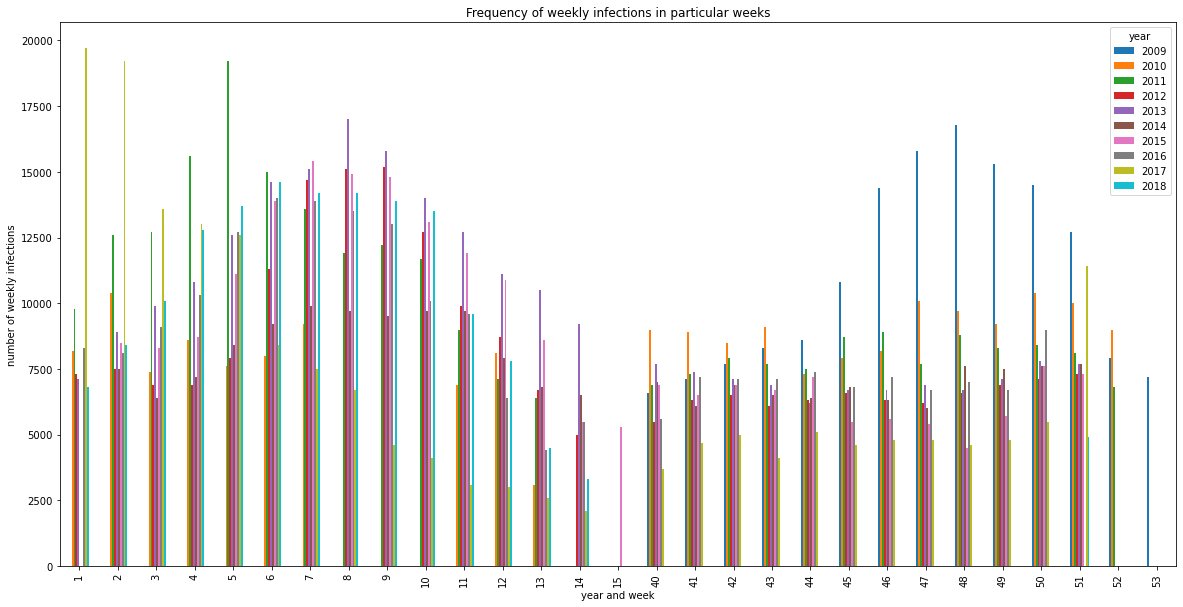

<ipython-input-8-288085a35026>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 75)
<ipython-input-8-288085a35026>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


In [ ]:
labels = [' ', 'weekly_infections', 'temp_weeklyMin', 'temp_weeklyMax',
       'temp_weeklyMean', 'temp_7h_weeklyMedian', 'temp_14h_weeklyMedian',
       'temp_19h_weeklyMedian', 'hum_weeklyMean', 'hum_7h_weeklyMedian',
       'hum_14h_weeklyMedian', 'hum_19h_weeklyMedian', 'precip_weeklyMean',
       'windBeauf_14h_weeklyMedian']

data_merged.weekly_infections.unstack(level=0).plot(figsize = (20,10), kind='bar')
plt.ylabel('number of weekly infections')
plt.xlabel('year and week')
plt.title('Frequency of weekly infections in particular weeks')
plt.savefig('bar_frequency_weekly_infections' + '_01.png', bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(data_merged.corr(), interpolation='nearest')
fig.colorbar(cax)
ax.xaxis.tick_bottom()
ax.set_xticklabels(labels, rotation = 75)
ax.set_yticklabels(labels)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Correlation matrix')
plt.savefig('heatmap_corr_matrix' + '_02.png', bbox_inches = 'tight')
plt.show()

plt.scatter(data_merged['temp_weeklyMin'], data_merged['weekly_infections'])
plt.scatter(data_merged['temp_weeklyMax'], data_merged['weekly_infections'])
plt.scatter(data_merged['temp_weeklyMean'], data_merged['weekly_infections'])
plt.ylabel('weekly infections')
plt.xlabel('min(blue), max(orange) and mean(green) temperature')
plt.title('Relationship between infections and an outside temperature')
plt.savefig('scatter_temp_infections' + '_05.png', bbox_inches = 'tight')
plt.show()

plt.bar(data_merged['windBeauf_14h_weeklyMedian'], data_merged['weekly_infections'], width = 0.5)
plt.ylabel('weekly infections')
plt.xlabel('mean weekly wind according to Beaufort scale')
plt.title('Relationship between infections and windy weather')
plt.savefig('scatter_windBeauf_infections' + '_06.png', bbox_inches = 'tight')
plt.show()

## Task 7: Influenza prediction model 
Total number of points for completing this task: **35**


Build a model to predict the number of influenza incidents for the first part of the 2018/2018 Influenza season (`influenza_predict.csv`) based on data of previous year using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the actual data available for 2018 as a validation set?
 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from scipy import stats

column_names = ['Jahr', 'Kalenderwoche', 'Neuerkrankungen pro Woche']
data = pd.read_csv('../data/influenza/influenza_predict.csv', usecols=column_names)
influenza_predict_data = data.rename(columns={'Jahr':'year'
                                             ,'Kalenderwoche':'week'
                                             ,'Neuerkrankungen pro Woche':'weekly_infections'})
influenza_predict_data['week'] = influenza_predict_data['week'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
influenza_predict_data.set_index(['year', 'week'], inplace=True)
influenza_predict_data['weekly_infections'] = influenza_predict_data['weekly_infections']*1000
influenza_predict_data['weekly_infections'] = influenza_predict_data['weekly_infections'].astype(int)

data_merged_predict = merge_data(data_weather_weekly, influenza_predict_data)

target_column = ['weekly_infections']
predictors = list(set(list(data_merged.columns))-set(target_column))
data_merged[predictors] = stats.zscore(data_merged[predictors])
#data_merged.describe()

X = data_merged[predictors].values
y = data_merged[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
#print(X_train.shape); print(X_test.shape)

####Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train.ravel()) 
pred_train_lr = lr.predict(X_train)

pred_test_lr = lr.predict(X_test)
print("RMSE of testing data for Linear Regression:\t",np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print("R2 of testing data  for Linear Regression:\t",r2_score(y_test, pred_test_lr))

pred_final_data_lr = lr.predict(data_merged_predict[predictors])
print("Train:\n", pred_train_lr)
print("\nTest:\n", pred_test_lr)
print("\nFinal prediction:\n", pred_final_data_lr)

#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

Your answer here

#### Findings  <span style="color:blue">(2 P)</span>
Summarize your findings and lessens learned.

Your answer here